### Group Members:

- Omkar Ingale, 24-716-466
- Name, matriculation number
- Name, matriculation number

# Assignment 4: Auto-Encoder (AE), Out-of-Distribution (OOD) Detection and Open-Set Recognition (OSR)

In this assignment, we show that it is possible to perform a (non-linear) dimensionality reduction by learning from unlabeled data using a convolutional auto-encoder network.
The task is to reduce an image of the handwritten digits of MNIST into a deep feature representation, without making use of their labels, and reconstruct the sample from that representation.

For this purpose, we implement a convolutional auto-encoder that is composed of two sub-networks.
An *encoder* network composed of several strided convolution layers, which finally performs an embedding in a $K=10$-dimensional deep feature representation.
The *decoder* uses this deep feature representation to reconstruct an image in the original size of $28\times28$ pixels by applying a series of fractionally-strided transposed convolutional layers.

After training such a network, we show that this has learned well the distribution of the known classes, which are represented by the MNIST test sample.
On the other hand, we show that this network has limited representation capabilities for *near OOD* samples coming from the related EMNIST letters dataset.
Also, we use *far OOD* samples coming from the Fashion-MNIST dataset to show that such samples are not represented in the embedding space of our auto-encoder.

For both of these types of OOD samples, we show that our auto-encoder network can be used to detect out-of-distribution data in the test set, and perform open-set recognition.
Particularly, we make use of the reconstruction error of our auto-encoder to distinguish known and OOD samples.
Additionally, we compute centroids of embedding vectors for all known classes, and use distances to such classes for classification.

## Section 1: Theoretical Questions

In this section we first investigate core questions regarding auto-encoder networks, for example, how to achieve a vector representation for the deep features. Afterward, we discuss some characteristics of approaches to open-set recognition.

### Task 1.1: PCA vs. Two-Layer Autoencoder

Principal Component Analysis (PCA) and two-layer AutoEncoders (AE) are two different ways for projecting a vector input vector $\vec x \in \mathbb R^D$ into a vector representation $\vec \varphi \in \mathbb R^K$ with $K \ll D$.
In both cases, a projection matrix $\mathbf W$ is learned to perform this task.
For PCA, this projection is applied as $\vec\varphi = \mathbf W(\vec x - \tilde x)$ where $\tilde x$ is the mean of the samples over the training set.
A two-layer autoencoder is composed of an encoder with one fully-connected layer $\mathbf W^{(1)} \in \mathbb R^{K\times(D+1)}$, and a decoder containing one fully-connected layer $\mathbf W^{(2)} \in \mathbb R^{(K+1)\times D}$, each including a bias neuron.

**Question**: What is the difference between PCA and the two-layer autoencoder with respect to the embedding matrix $\mathbf W$, and the learning procedure? Is there any theoretical difference how the bias is handled between the two methods?

**Answers** ...

### Task 1.2: Options for One-Dimensional Feature Vectors in Latent Space

In a convolutional autoencoder, the encoder typically employs a series of convolutional layers, which provides feature maps $\mathcal A\in\mathbb R^{Q\times K\times M}$.
The embedding vector, however, is required to be a vector with a desired number of elements.

**Question**: What are the different approaches to obtaining a one-dimensional feature vector in the latent space of autoencoders?

**Answers**: ...

### Task 1.3: Two-Step Approach for OSR - Pros and Cons

In open-set recognition, two-stage approaches first perform a binary classification of a sample to be *known* or *unknown*, and then classify all *known* samples as their respective class.

**Question**: What are the advantages and disadvantages of employing such a two-step approach for Open-Set Recognition?

**Answers**: ...

### Task 1.4: Entropic Open-Set (EOS) Loss Bias

The Entropic Open-Set (EOS) loss aka. the Softmax Adaptation requires having no bias in the final fully-connected layer that transforms the deep features $\vec\varphi$ to the logits: $\vec z = W^{(L)} \vec\varphi$.

**Question**: Why is it theoretically impossible to introduce a bias for the Entropic Open-Set (EOS) loss?

**Answer**: ...

### Task 1.5: Selection of Negative Samples

EOS loss requires *negative* samples for training.

**Question**: Given a specific set of known classes, how should negative samples be selected? Can random noise be used as negatives?

**Answer**: ...

### Task 1.6: Training with Negative Samples for Different OOD Detection Approaches

As mentioned above, we will make use of two methods for performing Out-of-Distribution (OOD) detection.
One is based on thresholding reconstruction error values, and one is based on distances in deep feature space.
More details on these two methods can be found at later sections in this notebook.

Theoretically, we could add the training samples of our unknown datasets (EMNIST letters, FashionMNIST) to our original training data (MNIST), and use all of these to train our autoencoder network.

**Question**: What do you expect: Is it advisable to train with additional samples when using autoencoders for OOD detection? Is there a difference between the two methods for OOD, i.e., thresholding reconstruction error or thresholding distances to class centroids in the deep feature space?

**Answer**: ...

## Section 2: Coding

**<font color='red' size='5'>This section has to be submitted by 11:59 p.m. on Wednesday, May 7th, to be graded.</font>**

The coding part is threefold.
First, we define everything that is required to train and evaluate our autoencoder network.
This includes the data sets used for training, validation and testing, as well as the datasets that serve as unknown samples for the OOD detection.

Afterward we define our convolutional autoencoder by defining an `Encoder` module and a `Decoder` module, which we combine to an auto-encoder.
We instantiate the auto-encoder and all other variables needed for training, and implement the training and validation loop.
Finally, we train our auto-encoder on our training dataset.

Finally, we use two different techniques for out-of-distribution detection using our train autoencoder network.
First, we use the reconstruction error on our known and unknown datasets to distinguish between known and unknown samples.
Then, we use distances in deep feature space to perform the same task.

In [1]:
# import required packages
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Using GPU')
else:
    print('Using CPU. Warning: This will be slow!')

Using GPU


### Task 2.1: Datasets and Data Loaders

We will make use of `torchvision.datasets.EMNIST` dataset and `torchvision.datasets.FashionMNIST` dataset.
EMNIST has two splits, `mnist` and `letters`, with 10 labels of digit images and 26 labels of letter images respectively.
FashionMNIST has 10 labels of merchandise images.
However, for the training of the Auto-Encoder (AE) we do not make use of the labels of the dataset, but we only utilize the images.
For testing purposes, we assign label `-1` to all unknown samples -- note that this is different from the theoretical part in the lecture, where we assign label `0` as unknown.

These datasets can be split into train sets and test sets by the default implementation.
We will use solely the MNIST split for training and validation of the AE network.
To evaluate this network for out-of-distribution detection, we will use the test sets from EMNIST letters and FashionMNIST respectively.

1. Create the `train_dataset` for the EMNIST `mnist` split.
2. Create test datasets for all datasets. For the test data loaders set `shuffle=True` for the sampling of images to be simpler, even though normally we would not shuffle the test set.
3. Create dataloaders for all datasets.

In [2]:
# Hyperparameters
batch_size = 128

# MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
# Create dataset with open-set samples (EMNIST letters)
def rotate_image(image):
    # Rotate the image by 90 degrees
    return image.transpose(2, 1)
emnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    rotate_image,
])

# training set of mnist digits
train_dataset = torchvision.datasets.EMNIST(
    root='./data_emnist',
    split="mnist",
    train=True,
    download=True,
    transform=emnist_transform,
    target_transform= lambda x: x-1
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# test dataset of mnist digits
test_dataset = torchvision.datasets.EMNIST(
    root='./data_emnist',
    split="digits",
    train=True,
    download=True,
    transform=emnist_transform,
    target_transform= lambda x: x-1
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# Create dataset and dataloader for EMNIST letters
emnist_letters_dataset = torchvision.datasets.EMNIST(
    root='./data_emnist',
    split="letters",
    train=True,
    download=True,
    transform=emnist_transform,
)
# Assign -1 label to all EMNIST letter samples
emnist_letters_dataset.targets = torch.full_like(
    emnist_letters_dataset.targets,
    fill_value=-1
)

emnist_letters_loader = DataLoader(
    emnist_letters_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)


# Create dataset and dataloader for FashionMNIST
fashion_mnist_dataset = torchvision.datasets.FashionMNIST(
    root='./data_fashionmnist',
    train=True,
    transform=transform,
    download=True,
)
# Assign -1 label to all FashionMNIST samples
fashion_mnist_dataset.targets = torch.full_like(
    fashion_mnist_dataset.targets,
    fill_value=-1
)
fashion_mnist_loader = DataLoader(
    fashion_mnist_dataset,
    shuffle=True,
    batch_size=batch_size,
    num_workers=2
)

# print the number of samples
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of EMNIST letters samples: {len(emnist_letters_dataset)}")
print(f"Number of FashionMNIST samples: {len(fashion_mnist_dataset)}")

100%|██████████| 562M/562M [00:12<00:00, 46.4MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]

Number of training samples: 60000
Number of test samples: 240000
Number of EMNIST letters samples: 124800
Number of FashionMNIST samples: 60000


We look at some images to get an idea of the data we are working with.
Notably, the letters are much more similar to the training data than the FashionMNIST data, therefore we call the letters near-OOD while the FashionMNIST data is far-OOD.

Note: We only look at the test sets now, to make sure that they are implemented correctly.

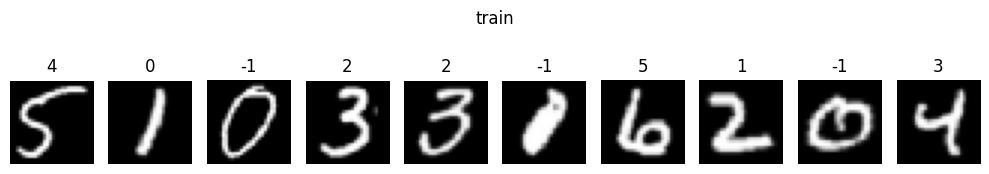

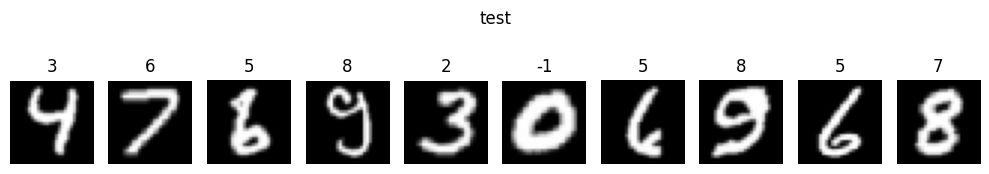

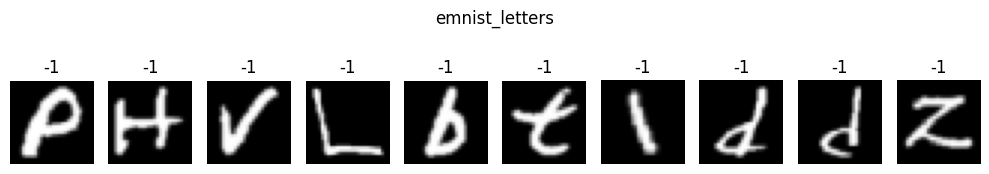

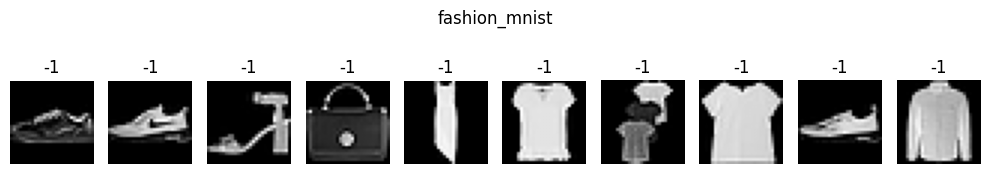

In [3]:
# look at some images from each dataset
def show_images(data_loader, title, nr_images = 10):
    # sample images from the dataset
    images, labels = next(iter(data_loader))
    fig, axs = plt.subplots(1, nr_images, figsize=(nr_images, 2))
    fig.suptitle(title)
    for i in range(nr_images):
        axs[i].imshow(images[i][0], cmap='gray')
        axs[i].set_title(labels[i].item())
        axs[i].axis('off')
    fig.tight_layout()
    plt.show()

datasets = {
    'train': train_loader,
    'test': test_loader,
    'emnist_letters': emnist_letters_loader,
    'fashion_mnist': fashion_mnist_loader
}
for name, loader in datasets.items():
    show_images(loader, name)

### Auto-Encoder Network

The auto-encoder network is composed of two parts: the encoder that transforms the input image to a deep feature representation; and the decoder that produces an image from such a deep feature.

For the encoder $\mathcal E$, we will use a convolutional network and perform down-sampling via striding.
After each convolution, we apply the ReLU activation.
The output of the encoder is a $K=10$ dimensional deep feature representation.
The complete encoder network topology can be found below in Topology 1(a).

The decoder $\mathcal D$ performs the inverse operations of the encoder.
A fully-connected layer is used to increase the number of samples to the same size as the output of the flattening of the encoder.
Then, the flattening needs to be undone by reshaping the vector into the correct dimensionality, followed by a ReLU activation.
A fractionally-strided convolutional layer increases the intermediate representation by a factor of 2.
Note that the fractionally-strided convolution is implemented in `torch.nn.ConvTranspose2d`, and the `stride` parameter should have the same value as for the encoder.
Additionally, the `torch.nn.ConvTranspose2d` has a parameter `output_padding` which needs to be adapted to reach the correct output shape (see Test 2).
After this layer, we perform another ReLU activation and another fractionally-strided convolution to arrive at the original input dimension.
The complete decoder network topology can be found below in Topology 1(b).

Finally, we combine the two sub-networks into one auto-encoder network.
While there exist several possibilities for doing this, we will implement a third `torch.nn.Module` that contains an instance of the encoder and an instance of the decoder.

Topology 1: Network configurations of the (a) encoder and (b) decoder networks

(a) Encoder Network

*   2D convolutional layer with $Q_1$ channels, kernel size $5\times5$, **stride 2** and padding 2
*   activation function ReLU
*   2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, **stride 2** and padding 2
*   flatten layer to convert the convolution output into a vector
*   activation function ReLU
*   fully-connected layer with the correct number of inputs and $K$ outputs

(b) Encoder Network

*   fully-connected layer with $K$ inputs and the correct number of outputs
*   activation function ReLU
*   reshaping to convert the vector into a convolution input
*   2D **fractionally-strided convolutional** layer with $Q_2$ channels, kernel size $5\times5$, stride 2 and padding 2
*   activation function ReLU
*   2D **fractionally-strided convolutional** layer with $Q_1$ channels, kernel size $5\times5$, stride 2 and padding 2

### Task 2.2: Encoder Network
Implement the encoder network for given parameters $Q_1$, $Q_2$, and $K$ as given in Topology 1(a).
Implement a network class that derives from `torch.nn.Module` and implement the `__init__` and the `forward` methods.

In [4]:
class Encoder(torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    # call base class constrcutor
    super(Encoder,self).__init__()
    # convolutional define layers
    self.conv1 = torch.nn.Conv2d(
        in_channels=1,
        out_channels=Q1,
        kernel_size=5,
        stride=2,
        padding=2,
    )
    self.conv2 = torch.nn.Conv2d(
        in_channels=Q1,
        out_channels=Q2,
        kernel_size=5,
        stride=2,
        padding=2,
    )
    # activation functions will be re-used for the different stages
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc = torch.nn.Linear(Q2*7*7 ,K)

  def forward(self, x):
    # get the deep feature representation
    deep_feature = self.act(self.conv1(x))
    deep_feature = self.act(self.conv2(deep_feature))
    deep_feature = self.fc(self.flatten(deep_feature))

    return deep_feature

### Task 2.3: Decoder Network

Implement the decoder network for given parameters $Q_1$, $Q_2$, and $K$ as given in Topology 1(b).
Implement a network class that derives from `torch.nn.Module` and implement the `__init__` and the `forward` methods.
The output of the decoder network is supposed to have values in the range $[0,1]$, similar to the input values.
We need to make sure that only these values can be achieved.
Think of possible ways of doing that, and apply the way that seems most reasonable.

In [5]:
class Decoder(torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    # call base class constrcutor
    super(Decoder,self).__init__()
    self.Q2 = Q2
    # fully-connected layer
    self.fc = torch.nn.Linear(K, Q2*7*7)
    # convolutional layers
    self.deconv1 = torch.nn.ConvTranspose2d(
        in_channels=Q2,
        out_channels=Q1,
        kernel_size=5,
        stride=2,
        padding=2,
        output_padding=1
    )
    self.deconv2 = torch.nn.ConvTranspose2d(
        in_channels=Q1,
        out_channels=1,
        kernel_size=5,
        stride=2,
        padding=2,
        output_padding=1
    )
    # activation function
    self.act = torch.nn.ReLU()
    self.act1 = torch.nn.ReLU()

  def forward(self, x):
    # reconstruct the output image
    output = self.fc(x)
    output = output.view(-1, self.Q2, 7, 7) # reshapre
    output = self.act(self.deconv1(output))
    output = self.act1(self.deconv2(output))
    return output

### Task 2.4: Joint Auto-Encoder Network

Implement the auto-encoder network by combining the encoder and the decoder.
In the `__init__` function, instantiate an encoder from Task 2 and a decoder from Task 3.
In `forward`, pass the input through the encoder and the decoder: $\mathbf Y = \mathcal D(\mathcal E(\mathbf X))$

In [6]:
class AutoEncoder(torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    super(AutoEncoder,self).__init__()
    self.encoder = Encoder(Q1, Q2, K)
    self.decoder = Decoder(Q1, Q2, K)

  def forward(self, x):
    # encode input
    deep_feature = self.encoder(x)
    # decode to output
    reconstructed = self.decoder(deep_feature)
    return reconstructed

### Test 1: Output Sizes

The code below instantiates the auto-encoder network with $Q_1 = Q_2 = 32$ and $K=10$.
Then the given input $\mathbf X$ is provided to the (untrained) auto-encoder network.
Use these codes to verify that the deep feature extracted by the encoder and the output from the decoder part both have the desired size. Also, verify that the output values are between 0 and 1.

If the tests cannot be passed, please check the implementations above.

In [7]:
# create network
model_ = AutoEncoder(32, 32, 10).to(device)

# create or select a sample
x = torch.randn((1,1,28,28), device=device)

# use encoder to encode image and check its size
deep_features_ = model_.encoder(x)
assert deep_features_.shape[1] == 10

# use decoder to generate an image and check its size and value range
output_ = model_.decoder(deep_features_)
assert output_.shape[2:] == (28,28)
assert torch.all(output_ >= 0) and torch.all(output_ <= 1)

# make sue that the auto-encoder is implemented correctly
output__ = model_(x)
assert output__.shape[2:] == (28,28)
assert torch.allclose(output_, output__)

## Training and Evaluation
We will implement a training procedure for an auto-encoder network.

To train the network, we will use the $L_2$ distance between the output and the input of the network as a loss function, which is implemented in `torch.nn.MSELoss`:

  $$\mathcal J^{L_2} (\mathbf X, \mathbf Y) = \|\mathbf X - \mathbf Y\|^2$$

For optimization, we will make use of the `Adam` optimizer with a learning rate of $\eta=0.001$.
We will run the training for 10 epochs and compute training and validation set loss after each epoch.

For evaluation, we will check whether some of the validation set samples are correctly reconstructed from the auto-encoder network by visualizing them.

In our test sets, there are 10000 in-distribution samples and 20800+10000 OOD samples.
In the case of evaluating the success rate of anomaly detection, accuracy is not the best metric because it gives equal weights to two classes with unequal numbers of samples, while the actual distribution of the two classes is unbalanced.
A system can achieve high accuracy by simply predicting the majority class for every instance, while completely ignoring the minority class.

In such cases, we choose to use the true positive rate (TPR) and true negative rate (TNR), which measure the proportion of actual positive/negative cases that are correctly identified by the system.

$$\text{TPR} = \frac{\text{True Positives}}{\text{True Positives+False Negatives}}$$

$$\text{TNR} = \frac{\text{True Negatives}}{\text{True Negatives+False Positives}}$$

### Task 2.5 Training Loop

Instantiate the auto-encoder network with $Q_1 = Q_2 = 32$ and $K=10$.

To train the auto-encoder network, we will use the $L_2$ distance between the output and the input of the network as a loss function.
This loss function is implemented in `torch.nn.MSELoss` and make sure to use `reduction='none'` as this will allow us to compute the loss for each sample separately, which will become important later.
This will keep the output size identical to the input size.
However, because we still need to compute the average loss for the backpropagation and to report the training and validation performance, we need to manually compute these averages.
For `sample_J`, compute the mean loss for each sample over the data dimensions.
For `J` compute the average of `sample_J` over the batch size.

Since training an auto-encoder is tricky, we will make use of the Adam optimizer.
Choose a learning rate of $\eta=0.001$. Implement the training loop for 10 epochs.

Note: If the training and validation loss does not decrease during training, try to reduce the learning rate (to $\eta=0.0005$ or even lower) and re-start the training (remember to re-initialize the network, too).

In [8]:
# Initialize model
model =  AutoEncoder(32, 32, 10).to(device)

# Number of epochs
num_epochs = 10

# Loss function and optimizer
loss_function = torch.nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from tqdm import tqdm

# Training loop
def train():
    model.train()
    losses = []
    for X, _ in tqdm(train_loader):
        # Move data to device
        X = X.to(device)

        # Forward pass
        Y = model(X)
        # Compute loss per sample. sample_J is a tensor of shape (batch_size,)
        sample_J = loss_function(Y, X).mean(dim=(1, 2, 3))
        # Compute average loss over batch
        J = sample_J.mean()

        # Backward and optimize
        optimizer.zero_grad()
        J.backward()
        optimizer.step()

        # Add sample-wise loss to list
        losses.append(sample_J.detach().cpu())

    losses = torch.cat(losses)
    return losses

# test (i.e. Inference)
def test(data_loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for X, _ in tqdm(data_loader):
            # Move data to device
            X = X.to(device)

            # Forward pass
            Y = model(X)

            # Compute loss per sample. sample_J is a tensor of shape (batch_size,)
            sample_J = loss_function(Y, X).mean(dim=(1, 2, 3))

            # Add sample-wise loss to list
            losses.append(sample_J.detach().cpu())

    losses = torch.cat(losses)
    return losses

### Test 2: Loss Computation

We test that the shape of the loss values is correct to assure that the reduction is only applied to each image and the loss for each sample is reported separately.

With the default parameters from the tasks above, you can expect a loss of roughly 0.015-0.020 for the training and in-distribution test set after 10 epochs.

In [9]:
class RandomImageDataset(torch.utils.data.Dataset):
    def __init__(self, shape):
        self.shape = shape
        # Generate random samples and targets
        self.data = torch.rand(*self.shape)  # Random values between 0 and 1
        self.targets = torch.randint(0, 10, (self.shape[0],))  # Random integer labels from 0 to 9

    def __len__(self):
        return self.shape[0]

    def __getitem__(self, idx):
        if idx >= self.shape[0]:
            raise IndexError(f"Index {idx} out of range for dataset of size {self.shape[0]}")
        return self.data[idx], self.targets[idx]

data_size_ = 5
dataset_ = RandomImageDataset(shape=(data_size_, 1, 28, 28))
dataloader_ = DataLoader(dataset_, batch_size=data_size_, shuffle=False)
losses_ = test(dataloader_)

assert losses_.shape == (data_size_,)

100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Now, we train the model on our training dataset, and perform the validation on our validation dataset.
Since this is the same as in previous exercises, we have implemented this boring part for you.

In [10]:
# Training and validation
train_losses = []
validation_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    train_loss = train().mean()
    validation_loss = test(test_loader).mean()

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {train_loss:.6f}, Average Validation Loss: {validation_loss:.6f}')

Starting training...


100%|██████████| 1875/1875 [00:28<00:00, 66.05it/s]


Epoch [1/10], Average Train Loss: 0.036710, Average Validation Loss: 0.023256


100%|██████████| 1875/1875 [00:27<00:00, 67.16it/s]


Epoch [2/10], Average Train Loss: 0.021151, Average Validation Loss: 0.019442


100%|██████████| 1875/1875 [00:28<00:00, 66.48it/s]


Epoch [3/10], Average Train Loss: 0.018523, Average Validation Loss: 0.017709


100%|██████████| 1875/1875 [00:28<00:00, 66.67it/s]


Epoch [4/10], Average Train Loss: 0.017294, Average Validation Loss: 0.016867


100%|██████████| 1875/1875 [00:27<00:00, 67.40it/s]


Epoch [5/10], Average Train Loss: 0.016506, Average Validation Loss: 0.016229


100%|██████████| 1875/1875 [00:27<00:00, 67.36it/s]


Epoch [6/10], Average Train Loss: 0.016003, Average Validation Loss: 0.015866


100%|██████████| 1875/1875 [00:27<00:00, 67.83it/s]


Epoch [7/10], Average Train Loss: 0.015632, Average Validation Loss: 0.015480


100%|██████████| 1875/1875 [00:27<00:00, 67.56it/s]


Epoch [8/10], Average Train Loss: 0.015299, Average Validation Loss: 0.015196


100%|██████████| 1875/1875 [00:27<00:00, 67.45it/s]


Epoch [9/10], Average Train Loss: 0.015053, Average Validation Loss: 0.015060


100%|██████████| 1875/1875 [00:27<00:00, 67.22it/s]

Epoch [10/10], Average Train Loss: 0.014857, Average Validation Loss: 0.015115


Additionally, we plot the training and validation set losses.

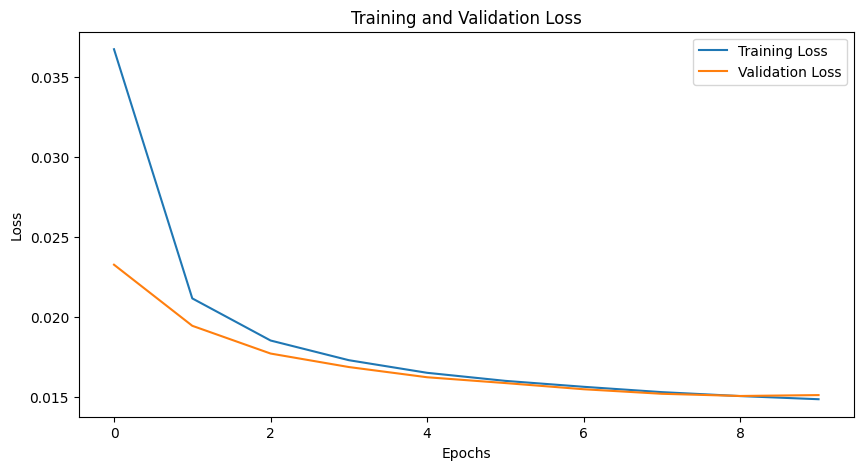

In [11]:
# Plot training and validation loss
def plot_losses():
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_losses()

## Out-of-Distribution (OOD) Detection

In this task, perform out-of-distribution (OOD) detection via the reconstruction error from the trained network.
We will use the test set of EMNIST letters and FashionMNIST as OOD samples.
We will first reconstruct the images of the three test sets.
Then we will perform OOD detection by computing the sample-wise loss thresholding the reconstruction error.
Samples with an error below a certain threshold are considered in-distribution, while samples with an error above the threshold are considered OOD.

Forward the re-assigned loss as predictions into the function defined above to compute TPR and TNR. Compute the regular accuracy as well to make a comparison.

### Task 2.6: Reconstruction Result

This task is to visualize the reconstructed images from their originals.
For this purpose, load the first batch of each of the test sets.
Forward the images through the trained auto-encoder network to extract their reconstructions.
Make a single plot with 2 rows and 10 columns.
In the 1st row, plot the original samples and in the 2nd row plot the corresponding reconstructed samples.

Then, for each dataset, compute the average reconstruction error of the entire dataset and print it.
Hint: you can reuse the `test()` function from task 2.5.

You should be able to see that the reconstruction error is much larger for the OOD samples (especially for far-OOD samples) than for the in-distribution samples.
This is a good sign that the auto-encoder network is able to detect OOD samples.

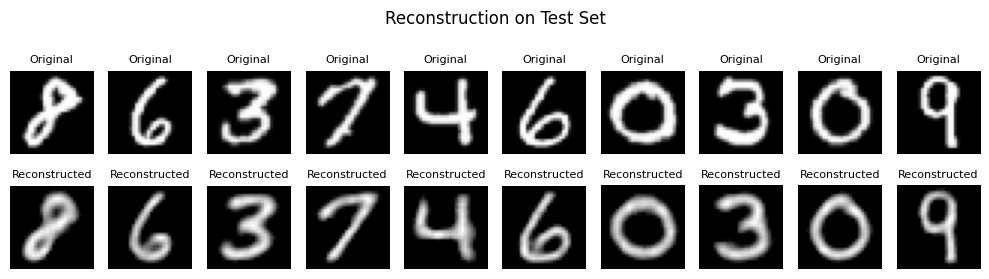

100%|██████████| 1875/1875 [00:28<00:00, 66.50it/s]

Average Test Reconstruction Error: 0.015115


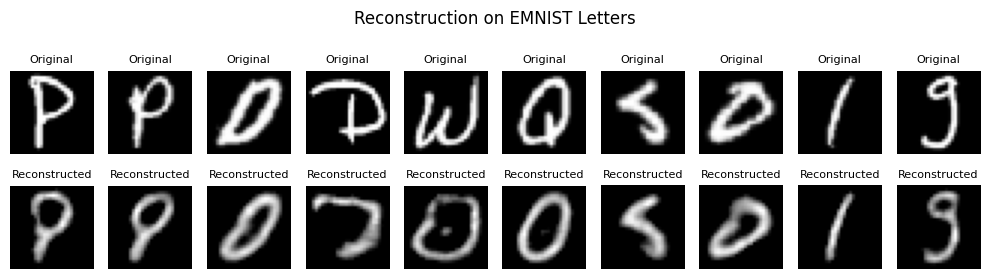

100%|██████████| 975/975 [00:14<00:00, 67.43it/s]

Average Open-set Test Reconstruction Error on EMNIST Letters: 0.038406


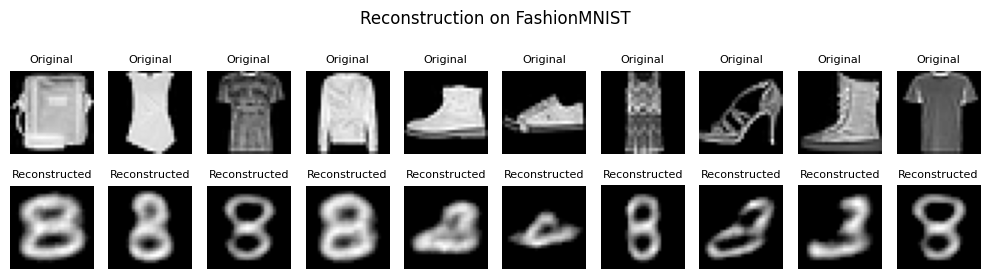

100%|██████████| 469/469 [00:07<00:00, 64.43it/s]

Average Open-set Test Reconstruction Error on Fashion MNIST: 0.077717


In [13]:
# Visualization of some reconstructed images
def visualize_reconstruction(data_loader, data_set_name, num_images=10):
    assert num_images <= batch_size, "num_images should be less than or equal to batch size"
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        X = next(iter(data_loader))
        X = X[0].to(device)

        # Generate reconstructions
        Y = model(X)

        # Move tensors to CPU
        X = X.cpu()
        Y = Y.cpu()

        # Plot original vs reconstructed images
        fig, axs = plt.subplots(2, num_images, figsize=(num_images, 3))
        fig.suptitle(f"Reconstruction on {data_set_name}")
        axs = axs.flatten()

        for i in range(num_images):
            # Original images
            ax = axs[i]
            ax.imshow(X[i][0], cmap='gray')
            ax.set_title("Original", fontsize=8)
            ax.axis('off')

            # Reconstructed images
            ax = axs[i + num_images]
            ax.imshow(Y[i][0], cmap='gray')
            ax.set_title("Reconstructed", fontsize=8)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

visualize_reconstruction(test_loader, "Test Set")
reconstruction_error_test = test(test_loader).mean()
print(f'Average Test Reconstruction Error: {reconstruction_error_test:.6f}')

# Visualize some open-set samples for EMNIST letters and FashionMNIST

# EMNIST letters
visualize_reconstruction(emnist_letters_loader, "EMNIST Letters")
# Evaluate reconstruction error on open-set samples
reconstruction_error_emnist = test(emnist_letters_loader).mean()
print(f'Average Open-set Test Reconstruction Error on EMNIST Letters: {reconstruction_error_emnist:.6f}')

# FashionMNIST
visualize_reconstruction(fashion_mnist_loader, "FashionMNIST")
# Evaluate reconstruction error on open-set samples
reconstruction_error_fashion = test(fashion_mnist_loader).mean()
print(f'Average Open-set Test Reconstruction Error on Fashion MNIST: {reconstruction_error_fashion:.6f}')

### Task 2.7: Visualizing the OOD Signal

We now exploit the inability of the AE network to reconstruct OOD samples, by using the reconstruction error as a signal for OOD detection and applying a threshold to the reconstruction error.
Determine a reasonable `ood_threshold` from the plot of this task (you need to run the plotting with value `0` first, and then you can decide for a good threshold) that can be used classify the samples as in-distribution or OOD.
Compute and plot the distribution of test errors on all three datasets as a histogram along with the threshold, in order to visualize the OOD detection performance.

100%|██████████| 469/469 [00:06<00:00, 75.54it/s]


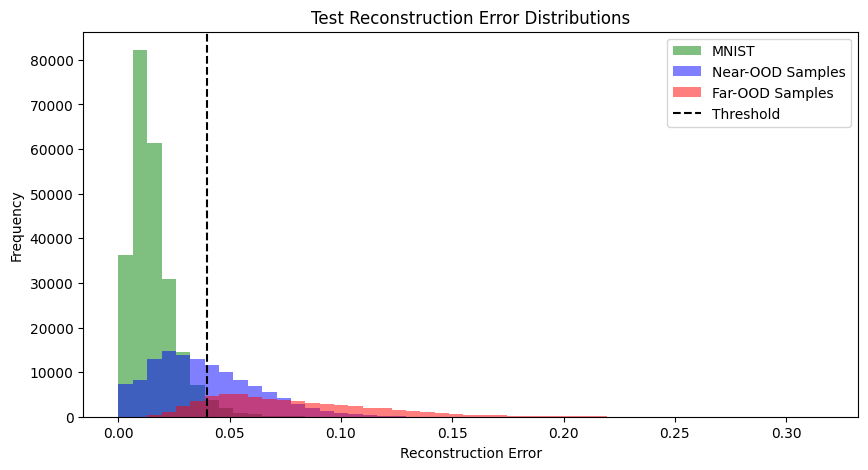

In [14]:
def plot_reconstruction_error_distributions(test_loader, near_ood_loader, far_ood_loader, threshold):
    test_errors = test(test_loader).numpy()
    near_ood_errors = test(near_ood_loader).numpy()
    far_ood_errors = test(far_ood_loader).numpy()

    all_errors = torch.cat([torch.tensor(test_errors), torch.tensor(near_ood_errors), torch.tensor(far_ood_errors)])

    plt.figure(figsize=(10, 5))
    bins = torch.linspace(0, all_errors.max(), 50)
    plt.hist(test_errors, bins=bins, alpha=0.5, color='green', label='MNIST')
    plt.hist(near_ood_errors, bins=bins, alpha=0.5, color='blue', label='Near-OOD Samples')
    plt.hist(far_ood_errors, bins=bins, alpha=0.5, color='red', label='Far-OOD Samples')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Test Reconstruction Error Distributions')
    plt.legend()
    plt.show()

# define a reasonable threshold for distinguishing ID and OOD samples, using this plot
ood_threshold = 0.04
plot_reconstruction_error_distributions(test_loader, emnist_letters_loader, fashion_mnist_loader, ood_threshold)

### Task 2.8: True Positive/Negative Rate Calculation

Define a function that takes the predictions and truth values, as lists, and returns TPR and TNR.

You can use `sklearn.metrics.confusion_matrix` (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to compute true positives, true negatives, false positives, and false negatives, or compute them by their definitions.


In [15]:
def compute_tpr_tnr(predictions, truth):
    # Compute the confusion matrix, directly from the torch tensors
    tn, fp, fn, tp = confusion_matrix(truth.cpu().numpy(), predictions.cpu().numpy(), labels=[1, -1]).ravel()
    # Compute TPR and TNR
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

    return tpr, tnr

### Test 3: TPR & TNR Calculation Check

With the given truth values and predictions, call the function defined in Task 2.8 and check the returned TPR and TNR are correct.

In [ ]:
truth = torch.tensor([1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1])
predictions = torch.tensor([1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1])

# Compute FMR and FNMR
tpr, tnr = compute_tpr_tnr(predictions, truth)

assert(abs(tpr - 14/15) < 1e-8)
assert(abs(tnr - 0.8) < 1e-8)

### Task 2.9: Evaluating OOD Detection

Now we will perform OOD detection by computing the sample-wise loss
In order to evaluate the performance, we need to convert the labels into binary labels and assign binary predictions.
Assign 1 to samples with a reconstruction error smaller than your `ood_threshold`, and -1 otherwise.
We adjust the labels accordingly.
Then, compute the TPR and TNR for the three datasets.

In [ ]:
predictions = []
labels = []
for dataloader in [test_loader, emnist_letters_loader, fashion_mnist_loader]:
    losses = ...

    # Compute binary predictions and labels: 1 for in-distribution, -1 for out-of-distribution
    binary_prediction = ...
    binary_labels = torch.where(dataloader.dataset.targets == -1, -1, 1)

    predictions.append(binary_prediction)
    labels.append(binary_labels)
predictions = torch.cat(predictions)
truth = torch.cat(labels)

# Compute TPR and TNR
tpr, tnr = compute_tpr_tnr(predictions, truth)
print(f'True Positive Rate (TPR): {tpr:.6f}')
print(f'True Negative Rate (TNR): {tnr:.6f}')

## Open-Set Recognition

So far we have ignored the class labels of the training data and only made the binary distinction between in and out-of-distribution samples.
In this task, we will use the class labels of the training data to perform open-set recognition, which also considers the class labels of the in-distribution samples.
We will show that we can solve the in-distribution classification task with the encoder network that was trained in an unsupervised fashion.

### Task 2.10: OSR via Class Distance

We will perform the in-distribution classification task by computing class centroids, i.e. the average deep feature representations of the training data for each class.
Then we will compute the Euclidean distance between the deep feature representation of the test sample and the class centroids.
The class with the smallest distance is assigned to the test sample.
Instead of using the reconstruction error as a signal of OODness, we will use the distance between the deep feature representation of the sample and the class centroids as signal of OODness and apply a threshold to the minimal distance of any test sample to all class centroids.

- Compute the class centroids for the training set.
    - Store them in a torch tensor of shape ($O$, $K$), where $K$ is the deep feature dimension and $O$ is the number of known classes.
    - It is advised to compute a dictionary first with the class labels as keys and a list of all the deep feature representations as values, then compute the mean of each list and store it in the tensor.
- Compute the distances of each sample to each class center. Use the `torch.cdist` function to compute the Euclidean distances for an entire batch at once.
- Predict the classes for the test samples as follows:
    - If for a sample the minimum distance to any class centroid is larger than the `osr_threshold`, assign it the label `-1` (unknown).
    - Otherwise, assign it the label of the class centroid with the smallest distance.

In [ ]:
class OSRClassifier():
    def __init__(self, autoencoder):
        self.encoder = autoencoder.encoder
        self.decoder = autoencoder.decoder

    def compute_centroids(self, data_loader):
        self.encoder.eval()
        class_features = {}
        with torch.no_grad():
            for X, Y in data_loader:
                deep_features = ...
                for i, label in enumerate(Y):
                    # append features for this label
                    class_features[label.item()].append(...)

        # Initialize centroids in reasonable data structure
        self.centroids = ...
        # Compute the mean of the deep features for each class
        for label in class_features:
            self.centroids[label] = ...

    def compute_distances(self, data_loader):
        self.encoder.eval()
        distances = []
        labels = []
        with torch.no_grad():
            for X, Y in data_loader:
                # extract deep features from the autoencoder
                deep_features = ...

                # Compute distances to all centroids for each sample
                dist = ...
                distances.append(dist)
                labels.append(Y)

        distances = torch.cat(distances)
        labels = torch.cat(labels)

        return distances, labels

    def predict(self, data_loader, threshold):
        self.encoder.eval()
        # compute distances to the stored centroids
        distances, Y = ...

        # Make predictions based on the threshold
        predictions = ...

        return predictions, Y

    def plot_centroid_reconstruction(self, num_images=10):
        self.encoder.eval()
        with torch.no_grad():

            reconstruction = self.decoder(self.centroids.clone().to(device)).cpu()

            # Plot the centroids
            fig, axs = plt.subplots(1, num_images, figsize=(num_images, 2))
            fig.suptitle("Centroid Reconstructions")
            for i in range(num_images):
                axs[i].imshow(reconstruction[i][0], cmap='gray')
                axs[i].set_title(f"Class {i}")
                axs[i].axis('off')
            plt.show()

# Create OSR classifier for the autoencoder
osr_classifier = OSRClassifier(model)
# compute centroids for the training set
osr_classifier.compute_centroids(train_loader)
# Plot reconstructed centroids
osr_classifier.plot_centroid_reconstruction(num_images=10)

### Task 2.11: Visualization of Distances to Class Centroids
Plot the distances of the test samples to the class centroids as a histogram.
Make sure to plot the distances for the three datasets in a single plot.
Assign `ood_threshold=0` in the first round to plot the distributions.
Then, set it to a reasonable value and call this plot again.

In [ ]:
# plot distances of the validation set
def plot_distances(osr_classifier, test_loader, near_ood_loader, far_ood_loader, threshold):
    test_distances = ...
    near_ood_distances = ...
    far_ood_distances = ...

    # compute min distances
    test_distances = ...
    near_ood_distances = ...
    far_ood_distances = ...

    # concatenate distances
    all_distances = torch.cat([test_distances, near_ood_distances, far_ood_distances])

    plt.figure(figsize=(10, 5))
    bins = torch.linspace(0, all_distances.max(), 50)
    plt.hist(test_distances, bins=bins, alpha=0.5, color='green', label='MNIST')
    plt.hist(near_ood_distances, bins=bins, alpha=0.5, color='blue', label='Near-OOD Samples')
    plt.hist(far_ood_distances, bins=bins, alpha=0.5, color='red', label='Far-OOD Samples')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title('Distance to Class Centroids')
    plt.legend()
    plt.show()

osr_threshold = ...
osr_classifier.compute_distances(test_loader)
plot_distances(osr_classifier, test_loader, emnist_letters_loader, fashion_mnist_loader, osr_threshold)

### Task 2.12: OSR Evaluation

In this task, we will evaluate the performance of the open-set recognition system on the test sets.
We will use the same evaluation metrics as in the OOD detection task, i.e. TPR and TNR.
In addition, we compute the closed-set accuracy on the known classes and plot the corresponding confusion matrix.
Make sure to only compute the accuracy and confusion matrix on the known classes, i.e. the samples with labels 0-9.

Note: There exist evaluation metrics such as the OSCR (Open Set Classification Rate) that are more suitable for open-set recognition tasks, but we will use the TPR and TNR metrics for simplicity here.

In [ ]:
# compute TPR and TNR on all datasets
predictions = []
labels = []
for dataloader in [test_loader, emnist_letters_loader, fashion_mnist_loader]:
    pred, label = ...
    predictions.append(pred)
    labels.append(label)

predictions = torch.cat(predictions).cpu()
labels = torch.cat(labels).cpu()

# Compute binary predictions and labels: 1 for in-distribution, -1 for out-of-distribution
binary_labels = torch.where(labels == -1, -1, 1)
binary_predictions = torch.where(predictions == -1, -1, 1)

# Compute TPR and TNR
tpr, tnr = ...
print(f'True Positive Rate (TPR): {tpr:.6f}')
print(f'True Negative Rate (TNR): {tnr:.6f}')

# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    # compute accuracy
    acc = ...

    # Compute confusion matrix
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu(), labels=list(range(10)), normalize='pred')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm)
    plt.colorbar(plt.imshow(cm))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix (Closed-Set Accuracy: {acc:.2f})')
    plt.xticks(ticks=range(10), labels=range(10))
    plt.yticks(ticks=range(10), labels=range(10))
    plt.show()

# plot confusion matrix of known classes
plot_confusion_matrix(..., ...)